#Pet Ownership and Volunteering?

I found an interesting dataset from Edmonton, Canada, that surveys residents for demographics, and information on their pet ownership.  I noticed that they captured information on whether or not participants volunteered, and I wondered, *does pet ownership have a relationship with volunteering?*

What follows data cleaning, panel data, logistic regression modelling, and then prediction metrics gathered.

Overall, I found that there is no relationship between pet ownership and volunteering, but there is a small amount of evidence that educational attainment has a positive relationship with whether a participant volunteers. However, as the model does not explain volunteering very well, my confidence in this interpretation is low.

Either way, a fun dataset and exercise.

## Data Import and Cleaning

In [256]:
# prompt: can you bring in data from this endpoint as a pandas dataframe? https://data.edmonton.ca/resource/5i9e-rgab.json

# metadata here: http://www.opendatanetwork.com/dataset/data.edmonton.ca/5i9e-rgab

import pandas as pd
df = pd.read_json("https://data.edmonton.ca/resource/5i9e-rgab.json")
df.head()

,responsedate,completiondate,q18_ownpets,q19_petkinds_dog,q19_petkinds_bird,q19_petkinds_fish,q19_petkinds_cat,q19_petkinds_marsupial,q19_petkinds_insect,q19_petkinds_reptile,...,q26_licensefundingprompt,q24_licensingmethod_placement_of_in_person_kiosks_at_malls_or_community_events,q24_licensingmethod_at_my_local_pet_supply_store,q24_licensingmethod_at_my_veterinary_clinic,q24_licensingmethod_licensing_staff_member_at_off_leash_dog_parks,q24_licensingmethod_ability_to_pay_for_my_pet_license_with_my_property_taxes,q24_licensingmethod_smartphone_app,q24_licensingmethod_i_don_t_believe_that_any_additional_licensing_method_would_realistically_help_me_change_my_mind_and_start_licensing_my_pets,q24_licensingmethod_other,q9b_live_before_edmonton_study_profiling_questionnaire_2014
0,2015-05-19T21:44:00.000,2015-05-19T22:02:00.000,Yes,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-05-12T11:51:00.000,2015-05-12T11:55:00.000,Yes,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-05-12T09:19:00.000,2015-05-12T09:37:00.000,Yes,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-05-12T11:50:00.000,2015-05-12T12:05:00.000,Yes,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-05-15T13:04:00.000,2015-05-15T13:14:00.000,Yes,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [257]:
full_df = df.copy()

In [258]:

columns_to_sum = ['q19_petkinds_dog', 'q19_petkinds_bird',
                  'q19_petkinds_fish', 'q19_petkinds_cat',
                  'q19_petkinds_marsupial', 'q19_petkinds_insect',
                  'q19_petkinds_reptile', 'q19_petkinds_rodent', 'q19_petkinds_other']
df['sum_pet_types'] = df[columns_to_sum].sum(axis=1)

cols = ['q18_ownpets','q12_employment_status_study_profiling_questionnaire_2014',
        'q13_volunteer_study_profiling_questionnaire_2014',
        'q14a_primary_transportation_study_profiling_questionnaire_2014',
        'q15_household_income_study_profiling_questionnaire_2014',
        'q16_education_study_profiling_questionnaire_2014', 'sum_pet_types', 'q20_numberpets']
df = df[cols]

In [259]:
df[cols].head()

,q18_ownpets,q12_employment_status_study_profiling_questionnaire_2014,q13_volunteer_study_profiling_questionnaire_2014,q14a_primary_transportation_study_profiling_questionnaire_2014,q15_household_income_study_profiling_questionnaire_2014,q16_education_study_profiling_questionnaire_2014,sum_pet_types,q20_numberpets
0,Yes,Employed full-time (30+ hours a week),Yes,Bicycle,"$80,000 to $99,999",Post-graduate degree,1.0,1.0
1,Yes,Employed full-time (30+ hours a week),Yes,Car/truck/Van as DRIVER,"$100,000 to $149,000",University undergraduate degree,4.0,NaN
2,Yes,Employed full-time (30+ hours a week),No,Car/truck/van as PASSENGER,"$100,000 to $149,000",University undergraduate degree,2.0,2.0
3,Yes,Employed full-time (30+ hours a week),Yes,Car/truck/Van as DRIVER,"$80,000 to $99,999",University undergraduate degree,1.0,2.0
4,Yes,Employed full-time (30+ hours a week),Yes,Car/truck/Van as DRIVER,"$100,000 to $149,000",University undergraduate degree,2.0,2.0


<Axes: >

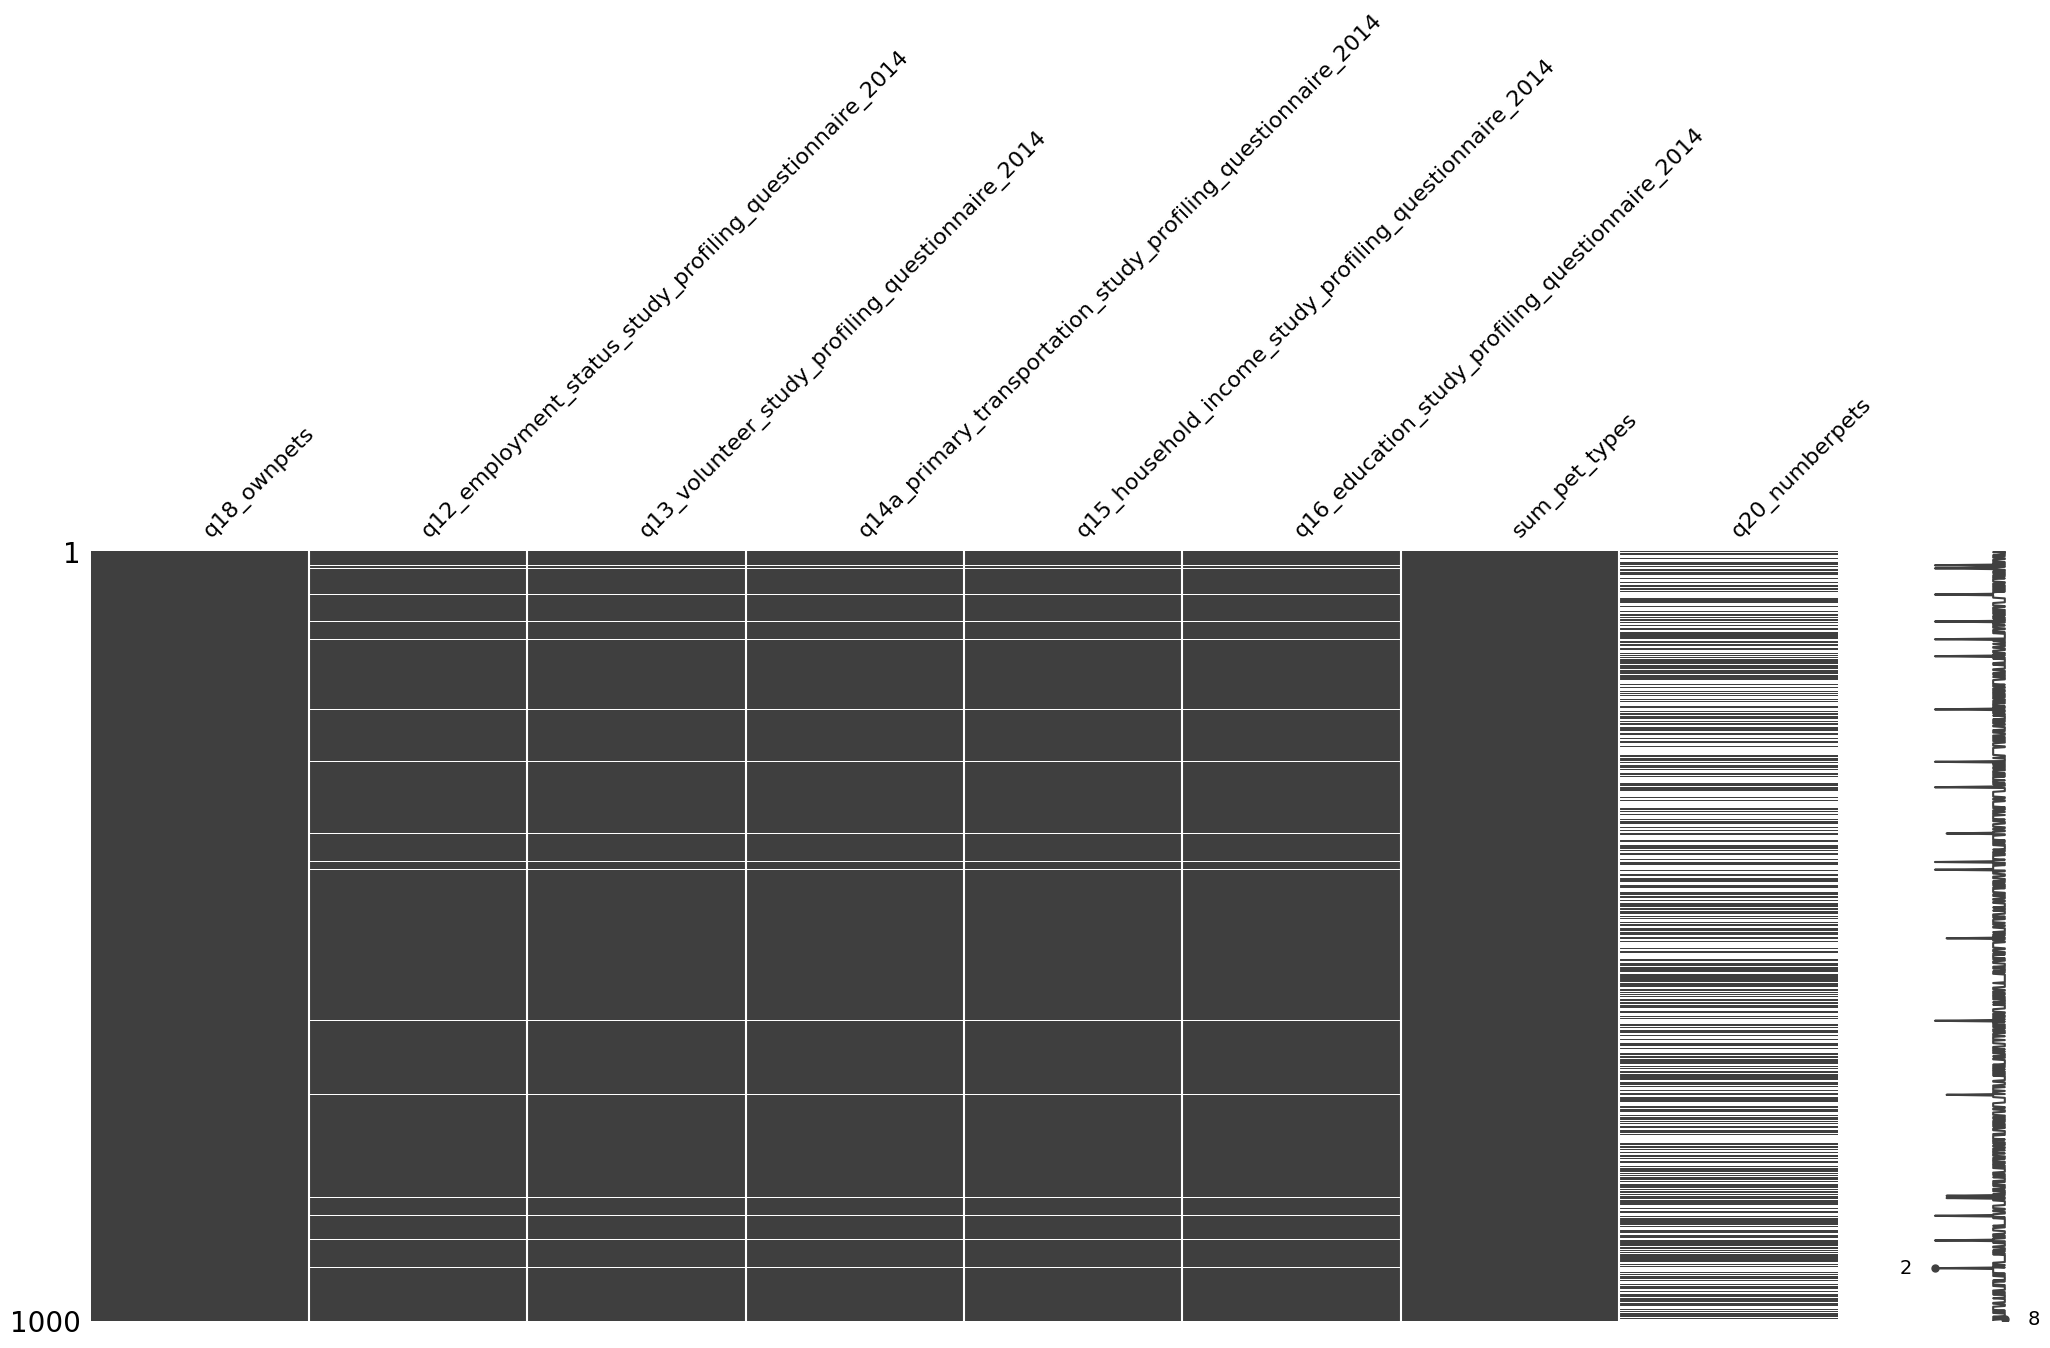

In [260]:
import missingno as msno
msno.matrix(df)

In [261]:
df.columns

Index(['q18_ownpets',
       'q12_employment_status_study_profiling_questionnaire_2014',
       'q13_volunteer_study_profiling_questionnaire_2014',
       'q14a_primary_transportation_study_profiling_questionnaire_2014',
       'q15_household_income_study_profiling_questionnaire_2014',
       'q16_education_study_profiling_questionnaire_2014', 'sum_pet_types',
       'q20_numberpets'],
      dtype='object')

In [262]:
#Q: In the last 12 months, did you do any activities without pay on behalf of a group or an organization as a volunteer?
df.q16_education_study_profiling_questionnaire_2014.value_counts()

,count
q16_education_study_profiling_questionnaire_2014,
University undergraduate degree,365
College / technical school graduate,229
Post-graduate degree,226
High school graduate,118
"Professional school graduate (e.g. medicine, dentistry, veterinary medicine, optometry)",36
Elementary/grade school graduate,6


In [263]:
# prompt: rename q13_volunteer_study_profiling_questionnaire_2014 as volunteer

df.rename(columns={'q13_volunteer_study_profiling_questionnaire_2014': 'volunteer',
                   'q15_household_income_study_profiling_questionnaire_2014':'household_income',
                   'q16_education_study_profiling_questionnaire_2014': 'educational_attainment'}, inplace=True)
print(df.columns)


Index(['q18_ownpets',
       'q12_employment_status_study_profiling_questionnaire_2014', 'volunteer',
       'q14a_primary_transportation_study_profiling_questionnaire_2014',
       'household_income', 'educational_attainment', 'sum_pet_types',
       'q20_numberpets'],
      dtype='object')


In [264]:
# create a dict of old and new values
recode = {"Employed full-time (30+ hours a week)": "Full Time",
          "Employed part-time (0-30 hours a week)": "Part Time",
          "Retired" : "Retired",
          "Homemaker" : "Homemaker",
          "Unemployed" : "Unemployed",
          "Post-secondary student" : "Student",
          "High School Student": "Student",
          "Permanently unable to Work": "Unable to Work",
          "Other (Specify)" : "Other"}

# recode the variable
df["employment"] = df["q12_employment_status_study_profiling_questionnaire_2014"].map(recode)

# check value counts
df.employment.value_counts()


,count
employment,
Full Time,652
Retired,116
Part Time,89
Student,33
Homemaker,33
Other,29
Unemployed,18
Unable to Work,10


In [265]:
df.educational_attainment.value_counts()

,count
educational_attainment,
University undergraduate degree,365
College / technical school graduate,229
Post-graduate degree,226
High school graduate,118
"Professional school graduate (e.g. medicine, dentistry, veterinary medicine, optometry)",36
Elementary/grade school graduate,6


In [266]:
# create a dict of old and new values
recode = {"University undergraduate degree": "Undergraduate",
          "College / technical school graduate": "College or Tech",
          "Post-graduate degree" : "Post-Graduate",
          "High school graduate" : "High School",
          "Professional school graduate (e.g. medicine, dentistry, veterinary medicine, optometry)" : "Professional Post-Graduate",
          "Elementary/grade school graduate" : "Grade School",
          }

# recode the variable
df.educational_attainment = df.educational_attainment.map(recode)

In [267]:
df = df.drop(columns =['q12_employment_status_study_profiling_questionnaire_2014','q14a_primary_transportation_study_profiling_questionnaire_2014','q20_numberpets'] )

In [268]:
edu_order = ['Grade School','High School',  'College or Tech',
             'Undergraduate', 'Post-Graduate', 'Professional Post-Graduate']

In [269]:
df['educational_attainment_encoded'] = pd.Categorical(df['educational_attainment'],
     categories=edu_order, ordered=True)

In [270]:
df.household_income.value_counts()

,count
household_income,
"$100,000 to $149,000",232
"$150,000 and over",171
Prefer not to answer,133
"$80,000 to $99,999",126
"$60,000 to $79,999",110
"$50,000 to $59,999",66
"$40,000 to $49,999",53
"$30,000 to $39,999",37
"$20,000 to $29,999",28


In [271]:
# prompt: I'd like an array that puts household income values in order

income_order = ['Under $25,000', '$25,000 to $49,999',
                '$50,000 to $74,999', '$75,000 to $99,999',
                '$100,000 to $124,999', '$125,000 to $149,999',
                '$150,000 to $199,999', '$200,000 and over',
                "Don't know", 'Prefer not to answer']
df['household_income_encoded'] = pd.Categorical(df['household_income'],
     categories=income_order, ordered=True)

In [272]:
import pandas as pd
income_order = ['Prefer not to answer', 'Under $20,000', '$20,000 to $29,999', '$30,000 to $39,999',
                '$40,000 to $49,999', '$50,000 to $59,999', '$60,000 to $79,999',
                '$80,000 to $99,999', '$100,000 to $149,000', "$150,000 and over"]
df['household_income_encoded'] = pd.Categorical(df['household_income'], categories=income_order, ordered=True)


## Graphing Distributions

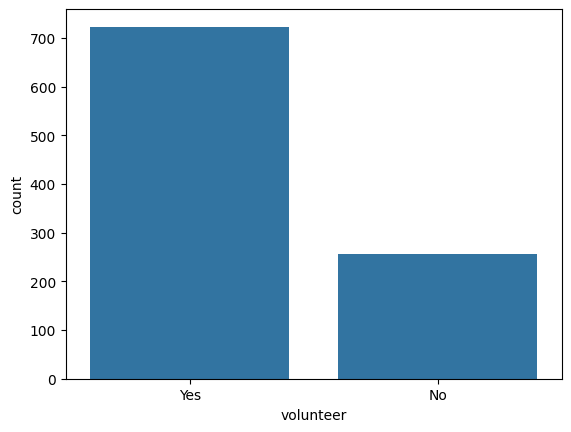

In [273]:
sns.countplot(x='volunteer', data=df)
plt.show()

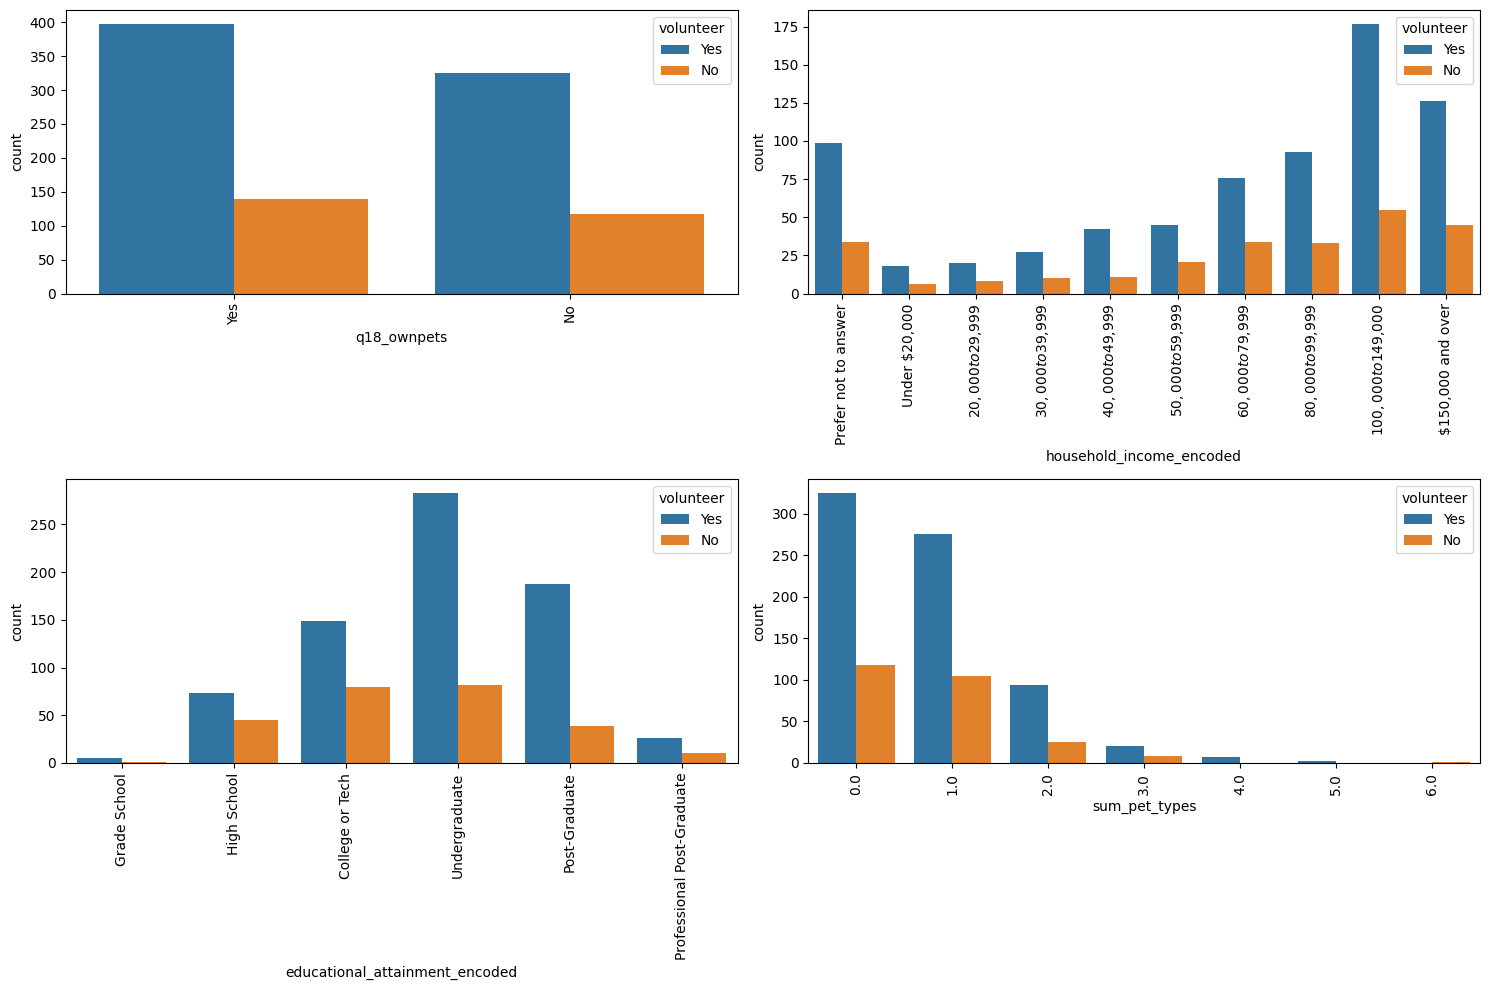

In [274]:
# prompt: can you graph the distribution of each of the columns using seaborn? and place each graph in a small grid side by side?

import seaborn as sns
import matplotlib.pyplot as plt

# Create a grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot the distribution of each column
sns.countplot(x='q18_ownpets', data=df, ax=axes[0, 0], hue='volunteer')
sns.countplot(x='household_income_encoded', data=df, ax=axes[0, 1], hue='volunteer')
sns.countplot(x='educational_attainment_encoded', data=df, ax=axes[1, 0], hue='volunteer')
sns.countplot(x='sum_pet_types', data=df, ax=axes[1, 1],hue='volunteer')

# Rotate x-axis labels for better readability
for ax in axes.flat:
  ax.tick_params(axis='x', rotation=90)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


Two-thirds of the dataset volunteers, and visually it seems as though these people are well spread out among all categories. But there could be a relationship here that's hard to visually detect.

In [275]:
print(f"nulls in the dataset:\n {df.isnull().sum()} ")

nulls in the dataset:
 q18_ownpets                        0
volunteer                         20
household_income                  20
educational_attainment            20
sum_pet_types                      0
employment                        20
educational_attainment_encoded    20
household_income_encoded          20
dtype: int64 


In [276]:
# prompt: how many nulls or NaNs are in df?
df = df.dropna()
df.isnull().sum()

,0
q18_ownpets,0
volunteer,0
household_income,0
educational_attainment,0
sum_pet_types,0
employment,0
educational_attainment_encoded,0
household_income_encoded,0


##Transform Dataframe for Modeling

In [277]:
label_encoder = LabelEncoder()
label_mappings = {}

# Encode categorical columns, preserving order for ordinal variables
for col in df.columns:
  if col in ['educational_attainment_encoded', 'household_income_encoded']:
    print('hsi')
    df[col] = df[col].cat.codes  # Use cat.codes to preserve order
  elif col in ['q18_ownpets', 'employment','volunteer']:
    df[col] = label_encoder.fit_transform(df[col])
    label_mappings[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print(label_mappings)
df.head()


hsi
hsi
{'q18_ownpets': {'No': 0, 'Yes': 1}, 'volunteer': {'No': 0, 'Yes': 1}, 'employment': {'Full Time': 0, 'Homemaker': 1, 'Other': 2, 'Part Time': 3, 'Retired': 4, 'Student': 5, 'Unable to Work': 6, 'Unemployed': 7}}


<ipython-input-277-7857706ae347>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = label_encoder.fit_transform(df[col])
<ipython-input-277-7857706ae347>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = label_encoder.fit_transform(df[col])
<ipython-input-277-7857706ae347>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

,q18_ownpets,volunteer,household_income,educational_attainment,sum_pet_types,employment,educational_attainment_encoded,household_income_encoded
0,1,1,"$80,000 to $99,999",Post-Graduate,1.0,0,4,7
1,1,1,"$100,000 to $149,000",Undergraduate,4.0,0,3,8
2,1,0,"$100,000 to $149,000",Undergraduate,2.0,0,3,8
3,1,1,"$80,000 to $99,999",Undergraduate,1.0,0,3,7
4,1,1,"$100,000 to $149,000",Undergraduate,2.0,0,3,8


In [278]:
df.drop(columns = ['educational_attainment', 'household_income'], inplace=True)

<ipython-input-278-f526ac3193dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns = ['educational_attainment', 'household_income'], inplace=True)


In [279]:
from sklearn.model_selection import train_test_split

X = df.drop('volunteer', axis=1)
y = df['volunteer']
# Split data into train and test sets, balancing according to 'volunteer'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (784, 5)
X_test shape: (196, 5)
y_train shape: (784,)
y_test shape: (196,)


In [280]:
X_train.head()

,q18_ownpets,sum_pet_types,employment,educational_attainment_encoded,household_income_encoded
36,0,0.0,0,5,8
124,1,1.0,0,3,7
317,0,0.0,4,3,3
660,1,1.0,3,3,7
285,0,0.0,0,3,4


## Modeling

In [281]:
import numpy as np
import statsmodels.api as sm

# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

# Add a constant to the independent variables
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Fit the logistic regression model with class weights
logit_model = sm.Logit(y_train, X_train_const)
result = logit_model.fit(method='bfgs', maxiter=1000, class_weight=class_weights_dict)

print(result.summary())


Optimization terminated successfully.
         Current function value: 0.560176
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
                           Logit Regression Results                           
Dep. Variable:              volunteer   No. Observations:                  784
Model:                          Logit   Df Residuals:                      778
Method:                           MLE   Df Model:                            5
Date:                Thu, 19 Sep 2024   Pseudo R-squ.:                 0.02733
Time:                        20:31:08   Log-Likelihood:                -439.18
converged:                       True   LL-Null:                       -451.52
Covariance Type:            nonrobust   LLR p-value:                 0.0001603
                                     coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

/usr/local/lib/python3.10/dist-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: class_weight. After release 0.14, this will raise.
  warnings.warn(


No effect of pet ownership on volunteering.  Educational attainment is the only significant predictor at the 0.05 alpha level.

The model does not do a great job of explaining the distribution of Volunteering. This is evidenced by the log-likelihood, which does not improve much between the full and null model.

This is not a huge surprise - it's very believable that there are  things outside of what is captured in these data that influence if a person volunteers or not.


In [282]:
coefficients = result.params
odds_ratios = pd.DataFrame({
    'Variable': coefficients.index,
    'Coefficient': coefficients.values,
    'Odds Ratio': np.exp(coefficients.values)
})

print(odds_ratios)

                         Variable  Coefficient  Odds Ratio
0                           const     0.028017    1.028413
1                     q18_ownpets    -0.413478    0.661346
2                   sum_pet_types     0.290896    1.337625
3                      employment     0.070421    1.072960
4  educational_attainment_encoded     0.364635    1.439989
5        household_income_encoded    -0.009459    0.990585


Educational attainment has a positive odds ratio, meaning that the odds of the outcome are higher in the more educated groups

In [283]:

# Create a baseline prediction (probability of positive response with all features at 0)
baseline_prediction = 1 / (1 + np.exp(-result.params['const']))

# Initialize lists to store results
features = []
coefficients_list = []
probability_changes = []
new_probabilities = []

# Iterate through the coefficients (excluding the intercept)
for feature, coefficient in coefficients.items():
  if feature != 'const':
    log_odds_change = coefficient # Calculate the change in log-odds for a one-unit increase in the feature
    probability_change = np.exp(log_odds_change) / (1 + np.exp(log_odds_change)) # Calculate the change in probability using the logistic function
    new_probability = baseline_prediction * probability_change # Calculate the new probability of a positive response

    # Append results to lists
    features.append(feature)
    coefficients_list.append(coefficient)
    probability_changes.append(probability_change)
    new_probabilities.append(new_probability)

# Create a DataFrame from the results
results_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients_list,
    'Probability Change': probability_changes,
    'New Probability': new_probabilities
})

results_df


,Feature,Coefficient,Probability Change,New Probability
0,q18_ownpets,-0.413478,0.398078,0.201827
1,sum_pet_types,0.290896,0.572215,0.290115
2,employment,0.070421,0.517598,0.262424
3,educational_attainment_encoded,0.364635,0.590162,0.299214
4,household_income_encoded,-0.009459,0.497635,0.252303


There is a large increase in probability of volunteering given educational attainment - 29%. I don't believe this is a trustworthy estimate, given that this model doesn't explain the distribution of volunteering well, as shown above.

In [284]:
from sklearn.metrics import accuracy_score, roc_auc_score

y_pred_prob = result.predict(X_test_const) # Calculate predicted probabilities for the test set
y_pred = (y_pred_prob >= 0.5).astype(int) # Predict classes for the test set

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

auc = roc_auc_score(y_test, y_pred_prob)
print("AUC:", auc)


Accuracy: 0.7397959183673469
AUC: 0.5485463150777552


The accuracy, or true positive rate, is not bad, but the AUC is hardly better than average.


 Better luck for me next time! Unfortunately, my data do not show much of a relationship between volunteering, pet ownership, or much else.